# SETUP

This is the main setup file for understanding the data I will be working with, the corresponding train, test, validation splits and all graphical insights into the phrasing and distribution of the data.



## DATA
From the HuggingFace site: https://huggingface.co/datasets/Kabatubare/medical

"The "Medical" dataset is a specialized subset curated from the larger MedDialog collection, featuring healthcare dialogues between doctors and patients. This dataset focuses on conversations from Icliniq, HealthcareMagic, and HealthTap. Written primarily in English, it is designed to serve a broad range of applications such as NLP research, healthcare chatbot development, and medical information retrieval. The dataset contains 24,000 rows."

In [1]:
# gather all the imports needed for the setup

import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import os

C:\Users\henry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now lets define the functions to load and split the data, and save to a json file.

In [2]:
def load_and_split_data(dataset_name="Kabatubare/medical", train_size=0.8, val_size=0.1, test_size=0.1):
  """
  Function to read in the dataset, and split into train, test, and validation data.

  @PARAMS:
    - dataset_name -> input data source
    - train_size   -> size for the training
    - val_size     -> size for the validation
    - test_size    -> size for the testing
  """
   # load the dataset from hugging face
  dataset = load_dataset(dataset_name)
  
  # Convert to list of dictionaries for easier handling
  data = dataset['train'].to_list()
  
  # create the splits!
  train_data, temp_data = train_test_split(
      data,
      train_size=train_size,
  )
  
  # split remaining
  relative_val_size = val_size / (val_size + test_size)
  val_data, test_data = train_test_split(
      temp_data,
      train_size=relative_val_size,
  )
  
  splits = {
      'data': data,
      'train': train_data,
      'validation': val_data,
      'test': test_data
  }
  
  # save the splits to json
  save_splits(splits)
  
  return splits

def save_splits(splits, output_dir="processed_data"):
    """
    Function to save the splits into json files.

    @PARAMS:
      - splits     -> train, val, test data
      - output_dir -> where the data is saved
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for split_name, split_data in splits.items():
        output_path = os.path.join(output_dir, f"{split_name}.json")
        try:
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(split_data, f, indent=2, ensure_ascii=False)
            print(f"Saved {split_name} data with {len(split_data)} examples")
        except Exception as e:
            print(f"Error saving {split_name}: {e}")

Now we can create a class to analyze each of the json files. This will gather common word info, calculate basic statistics, etc.

In [3]:
class MedDialogueAnalyzer:
    """
    Class to read in patient and doctor interactions and calculate basic statistics associated to the conversations.
    """
    def __init__(self, data):
        # save the data passed in for future access.
        if isinstance(data, str):
            with open(data, 'r') as f:
                self.data = json.load(f)
        else:
            self.data = data

        # only care about questions and answers
        self.questions = [str(item['Question']) for item in self.data]
        self.answers = [str(item['Answer']) for item in self.data]

    def basic_statistics(self):
        """
        Function to calculate the basic statistics for the words in the questions adn answers.
        """
        # lengths for questions
        question_word_lengths = [len(text.split()) for text in self.questions]
        question_char_lengths = [len(text) for text in self.questions]
        
        # lengths for answers
        answer_word_lengths = [len(text.split()) for text in self.answers]
        answer_char_lengths = [len(text) for text in self.answers]

        # comput the stats for each
        stats = {
            'Total Examples': len(self.data),
            'Question Statistics': {
                'Average Words': np.mean(question_word_lengths),
                'Max Words': max(question_word_lengths),
                'Min Words': min(question_word_lengths),
                'Average Characters': np.mean(question_char_lengths),
                'Max Characters': max(question_char_lengths),
                'Min Characters': min(question_char_lengths)
            },
            'Answer Statistics': {
                'Average Words': np.mean(answer_word_lengths),
                'Max Words': max(answer_word_lengths),
                'Min Words': min(answer_word_lengths),
                'Average Characters': np.mean(answer_char_lengths),
                'Max Characters': max(answer_char_lengths),
                'Min Characters': min(answer_char_lengths)
            }
        }

        return stats

    def get_common_words(self, n=20):
        """
        Function to get the most commonly occuring words in the quesitons and answers.

        @PARAMS:
            - n -> the number of words to return
        """
        def get_words(texts):
            words = []
            for text in texts:
                words.extend(word.lower() for word in text.split() 
                           if word.isalnum() and len(word) > 2)
            return Counter(words)

        return {
            'Question Common Words': get_words(self.questions).most_common(n),
            'Answer Common Words': get_words(self.answers).most_common(n)
        }

    def plot_length_distributions(self):
        """
        Function to plot the length of words, characters, etc. in the questions and answers.
        """
        plt.figure(figsize=(15, 5))

        # word length
        question_lengths = [len(text.split()) for text in self.questions]
        answer_lengths = [len(text.split()) for text in self.answers]

        plt.subplot(1, 2, 1)
        sns.histplot(data={
            'Questions': question_lengths,
            'Answers': answer_lengths
        }, multiple="layer", alpha=0.6)
        plt.title('Distribution of Text Lengths (Words)')
        plt.xlabel('Number of Words')
        plt.ylabel('Count')

        # character length
        question_chars = [len(text) for text in self.questions]
        answer_chars = [len(text) for text in self.answers]

        plt.subplot(1, 2, 2)
        sns.histplot(data={
            'Questions': question_chars,
            'Answers': answer_chars
        }, multiple="layer", alpha=0.6)
        plt.title('Distribution of Text Lengths (Characters)')
        plt.xlabel('Number of Characters')
        plt.ylabel('Count')

        plt.tight_layout()
        return plt.gcf()

    def analyze_question_types(self):
        """
        Function to determine what types of questions are being asked based on a question key.
        """
        question_markers = ['?', 'what', 'how', 'why', 'when', 'where', 'can', 'should', 'could', 'would']
        question_types = Counter()

        for text in self.questions:
            text_lower = text.lower()
            if '?' in text:
                question_types['Contains Question Mark'] += 1
            for marker in question_markers:
                if marker in text_lower:
                    question_types[f'Contains "{marker.capitalize()}"'] += 1

        return dict(question_types.most_common())

Finally, lets run the code!

C:\Users\henry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\henry\.cache\huggingface\hub\datasets--Kabatubare--medical. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Saved data data with 23437 examples
Saved train data with 18749 examples
Saved validation data with 2344 examples
Saved test data with 2344 examples

Analyzing data split...

=== Dataset Statistics ===

Total Examples:
23437

Question Statistics:
Average Words: 38.40
Max Words: 139.00
Min Words: 2.00
Average Characters: 199.68
Max Characters: 682.00
Min Characters: 11.00

Answer Statistics:
Average Words: 101.83
Max Words: 1308.00
Min Words: 1.00
Average Characters: 580.06
Max Characters: 7092.00
Min Characters: 2.00

=== Most Common Words ===

Question Common Words:
and: 25575
the: 22090
have: 12566
for: 9919
what: 8435
can: 8114
with: 6221
that: 6158
had: 6141
but: 6078
was: 5552
this: 4762
not: 4697
are: 4182
been: 3947
get: 3901
has: 3719
how: 3682
when: 3504
after: 3215

Answer Common Words:
the: 88055
and: 55790
you: 52996
your: 38293
that: 27029
for: 25936
are: 22041
can: 21429
not: 19546
have: 19522
with: 18611
this: 18464
but: 11987
may: 11682
will: 9332
from: 8186
get: 8131
s

<Figure size 1500x500 with 0 Axes>

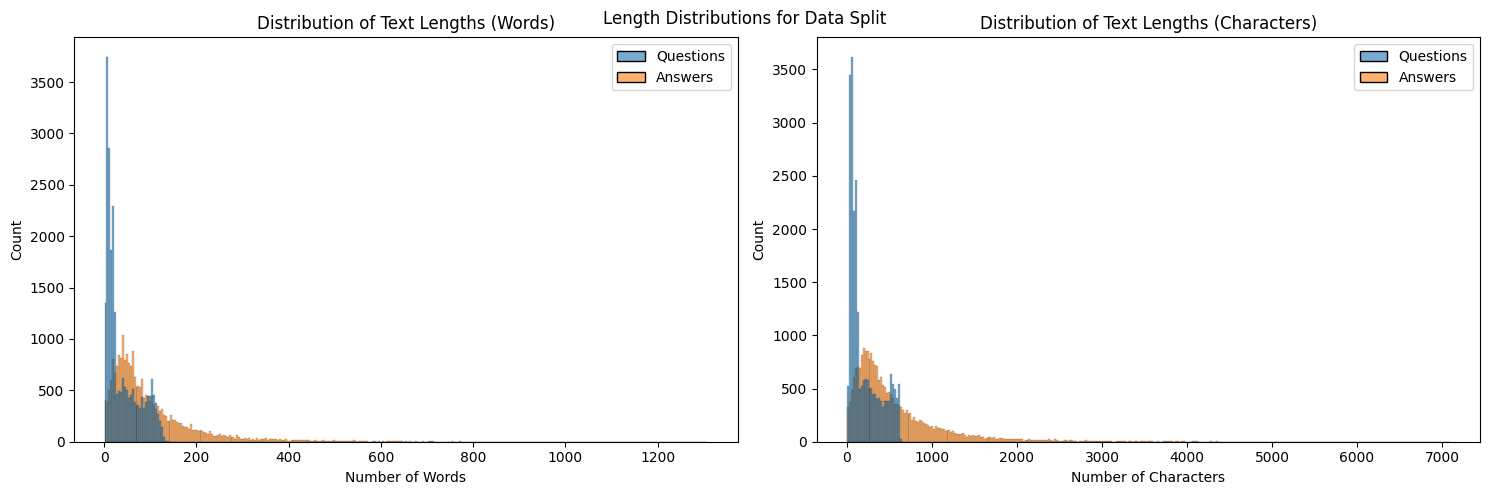


Analyzing train split...

=== Dataset Statistics ===

Total Examples:
18749

Question Statistics:
Average Words: 38.48
Max Words: 139.00
Min Words: 2.00
Average Characters: 200.14
Max Characters: 682.00
Min Characters: 12.00

Answer Statistics:
Average Words: 101.73
Max Words: 1308.00
Min Words: 1.00
Average Characters: 579.69
Max Characters: 7092.00
Min Characters: 2.00

=== Most Common Words ===

Question Common Words:
and: 20549
the: 17686
have: 9962
for: 7905
what: 6760
can: 6457
with: 5051
that: 4900
but: 4894
had: 4876
was: 4421
this: 3807
not: 3767
are: 3354
been: 3182
get: 3179
has: 3030
how: 2972
when: 2752
after: 2587

Answer Common Words:
the: 70129
and: 44451
you: 42345
your: 30834
that: 21514
for: 20786
are: 17643
can: 17111
not: 15621
have: 15538
with: 14919
this: 14868
but: 9591
may: 9361
will: 7368
from: 6574
get: 6457
some: 5815
there: 5809
would: 5750

=== Question Type Analysis ===
Contains Question Mark: 15735
Contains "?": 15735
Contains "Can": 6511
Contains "What

<Figure size 1500x500 with 0 Axes>

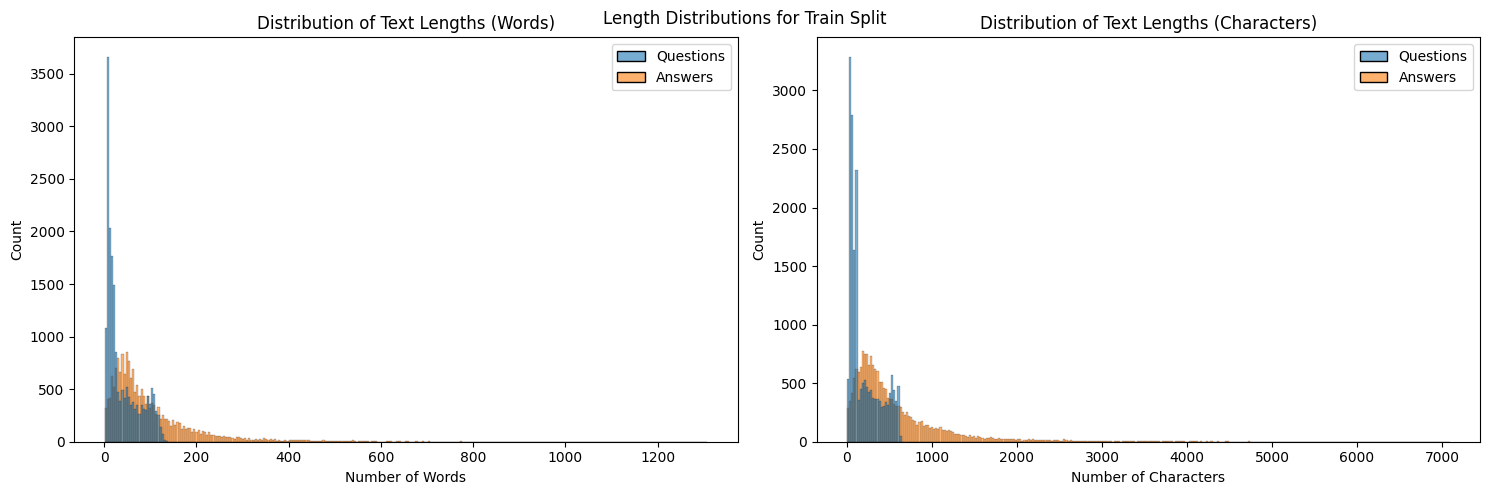


Analyzing validation split...

=== Dataset Statistics ===

Total Examples:
2344

Question Statistics:
Average Words: 37.93
Max Words: 131.00
Min Words: 3.00
Average Characters: 196.63
Max Characters: 630.00
Min Characters: 13.00

Answer Statistics:
Average Words: 101.39
Max Words: 979.00
Min Words: 1.00
Average Characters: 576.47
Max Characters: 5292.00
Min Characters: 2.00

=== Most Common Words ===

Question Common Words:
and: 2486
the: 2199
have: 1342
for: 1037
what: 830
can: 820
had: 626
with: 600
that: 599
but: 563
was: 524
this: 492
not: 463
been: 406
are: 393
when: 360
how: 354
get: 350
has: 338
after: 313

Answer Common Words:
the: 8916
and: 5556
you: 5238
your: 3730
that: 2679
for: 2578
can: 2123
are: 2094
have: 2014
not: 1995
with: 1847
this: 1739
may: 1207
but: 1188
will: 999
get: 813
from: 804
some: 775
there: 731
more: 712

=== Question Type Analysis ===
Contains Question Mark: 1962
Contains "?": 1962
Contains "Can": 811
Contains "What": 759
Contains "How": 407
Contains "

<Figure size 1500x500 with 0 Axes>

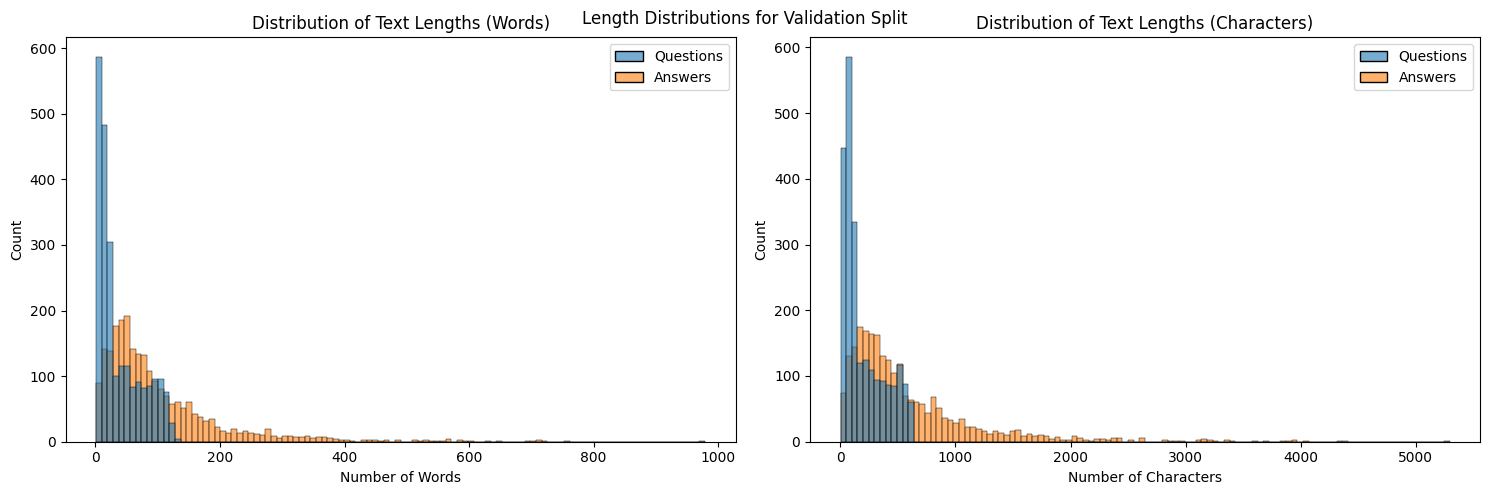


Analyzing test split...

=== Dataset Statistics ===

Total Examples:
2344

Question Statistics:
Average Words: 38.22
Max Words: 136.00
Min Words: 3.00
Average Characters: 199.06
Max Characters: 636.00
Min Characters: 11.00

Answer Statistics:
Average Words: 103.03
Max Words: 1148.00
Min Words: 1.00
Average Characters: 586.59
Max Characters: 6154.00
Min Characters: 3.00

=== Most Common Words ===

Question Common Words:
and: 2540
the: 2205
have: 1262
for: 977
what: 845
can: 837
that: 659
had: 639
but: 621
was: 607
with: 570
not: 467
this: 463
are: 435
when: 392
get: 372
been: 359
how: 356
has: 351
after: 315

Answer Common Words:
the: 9010
and: 5783
you: 5413
your: 3729
that: 2836
for: 2572
are: 2304
can: 2195
have: 1970
not: 1930
this: 1857
with: 1845
but: 1208
may: 1114
will: 965
get: 861
from: 808
they: 783
would: 767
some: 740

=== Question Type Analysis ===
Contains Question Mark: 1987
Contains "?": 1987
Contains "Can": 843
Contains "What": 768
Contains "How": 390
Contains "When":

<Figure size 1500x500 with 0 Axes>

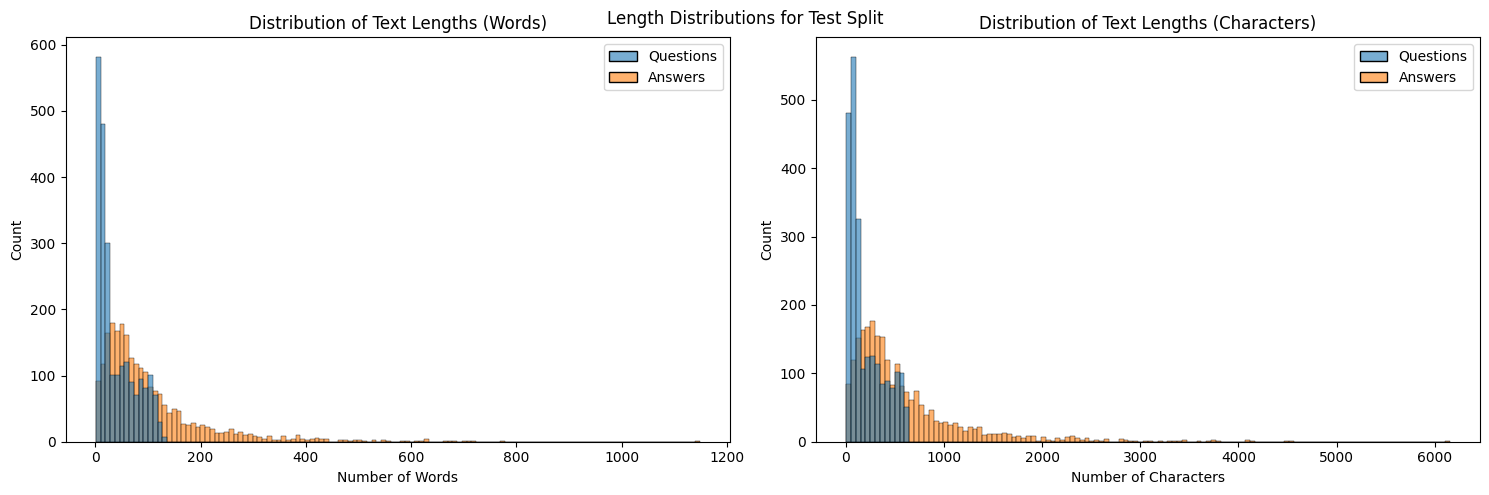

In [4]:
# load and split the data
splits = load_and_split_data()
    
# now run the analyzer on each of the files
for split_name, split_data in splits.items():
    print(f"\nAnalyzing {split_name} split...")
    analyzer = MedDialogueAnalyzer(split_data)
    
    # start with basic stats
    print("\n=== Dataset Statistics ===")
    stats = analyzer.basic_statistics()
    for category, values in stats.items():
        print(f"\n{category}:")
        if isinstance(values, dict):
            for key, value in values.items():
                print(f"{key}: {value:.2f}")
        else:
            print(values)
    
    # now common words
    print("\n=== Most Common Words ===")
    common_words = analyzer.get_common_words()
    for category, words in common_words.items():
        print(f"\n{category}:")
        for word, count in words[:20]:
            print(f"{word}: {count}")
    
    # now question types
    print("\n=== Question Type Analysis ===")
    question_types = analyzer.analyze_question_types()
    for qtype, count in question_types.items():
        print(f"{qtype}: {count}")
    
    # finally get the plots!
    plt.figure(figsize=(15, 5))
    analyzer.plot_length_distributions()
    plt.suptitle(f"Length Distributions for {split_name.capitalize()} Split")
    plt.show()